# Transfer learning project

## Introduction
  This document aims to practice and show the knowledge acquired regarding the topic of "transfer learning" in neural networks.By the end we will have trained two neural networks, one from scratch and another using the transfer learning technique, and compare both of them in order to evaluate the best case. The goal of each network is to classify a set of images to differentiate between dogs, cats and chickens.

  We will be using keras and tensorflow to train and run inferences. We will also be using 484 images for each category extracted from https://www.tensorflow.org/datasets/catalog/cats_vs_dogs (for cats and dogs). and https://github.com/gunthercox/chicken-photos/tree/master (for chickens)

## Setup



In [26]:
import os

import tensorflow as tf

tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)

import random
import numpy as np
import keras

import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.models import Model


### Download images 

  The images were stored in a google drive, each category in a different file.
  Here we download each file and recreate the dataset.

In [11]:
! wget -nv "https://drive.google.com/uc?export=download&id=1LsjVG1a-UzTNytoMph8YFhXQL6iFCyRK" -O dataset.tar.gz
! tar -xf dataset.tar.gz && rm dataset.tar.gz

! wget -nv "https://drive.google.com/uc?export=download&id=1FQxpmo1oeFu0FpVmRLKs5JhyburBnzT7" -O dataset.tar.gz
! tar -xf dataset.tar.gz && rm dataset.tar.gz

! wget -nv "https://drive.google.com/uc?export=download&id=1JgLakcUHbcgOhmcwWhCHUCNKuRWt2EHj" -O dataset.tar.gz
! tar -xf dataset.tar.gz && rm dataset.tar.gz


2025-02-02 14:13:38 URL:https://drive.usercontent.google.com/download?id=1LsjVG1a-UzTNytoMph8YFhXQL6iFCyRK&export=download [13612509/13612509] -> "dataset.tar.gz" [1]
2025-02-02 14:13:44 URL:https://drive.usercontent.google.com/download?id=1FQxpmo1oeFu0FpVmRLKs5JhyburBnzT7&export=download [16587496/16587496] -> "dataset.tar.gz" [1]
2025-02-02 14:13:50 URL:https://drive.usercontent.google.com/download?id=1JgLakcUHbcgOhmcwWhCHUCNKuRWt2EHj&export=download [18510721/18510721] -> "dataset.tar.gz" [1]


#### Load Images in a array
Each directory inside dataset represents a category.

In [12]:
root = 'dataset'
categories = [x[0] for x in os.walk(root) if x[0]][1:]
print(categories)

['dataset/Chicken', 'dataset/Dog', 'dataset/Cat']


In [18]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [19]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    p_imgs_errs = []
    for img_path in images:
      try:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})
      except Exception as e:
        p_imgs_errs.append(img_path)
    if p_imgs_errs: 
      print(f"{category}: {p_imgs_errs}")


### Preparing data

Here we prepare the loaded data for the algorithm. We normalize all the data, then shuffle to randomize and avoid bias. In the end split into 3 sets: for training, testing and validation.

In [20]:
# count the number of classes
num_classes = len(categories)
random.shuffle(data)

Separate data into sets.

In [21]:
train_split, val_split = 0.7, 0.15

idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))

train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]

x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]

x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

Normalize data and convert labels.

In [22]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [23]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 1452 images from 3 categories
train / validation / test split: 1016, 218, 218
training data shape:  (1016, 224, 224, 3)
training labels shape:  (1016, 3)


A few samples from our dataset.

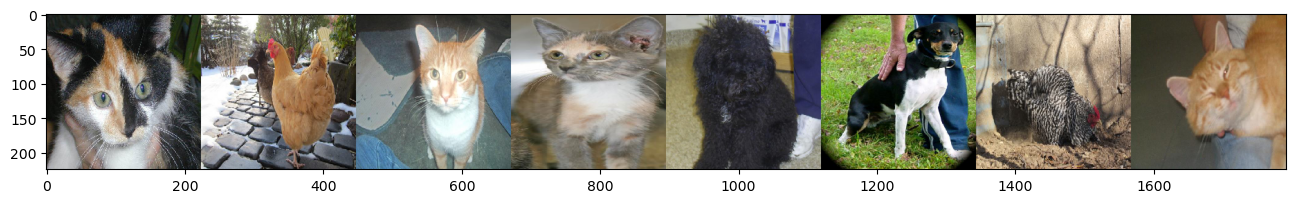

In [24]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)
plt.show()

## Training

### Baseline model

#### Build

In [34]:
# build the network
model = Sequential()

model.add(Input(x_train.shape[1:]))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           771 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,315 (4.61 MB)

 Trainable params: 1,209,315 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Train

In [35]:
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.3740 - loss: 1.1304 - val_accuracy: 0.3716 - val_loss: 1.0922
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.4564 - loss: 1.0811 - val_accuracy: 0.5413 - val_loss: 1.0134
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.5513 - loss: 0.9449 - val_accuracy: 0.5183 - val_loss: 0.8683
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.5936 - loss: 0.8205 - val_accuracy: 0.5596 - val_loss: 0.8338
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.6291 - loss: 0.7616 - val_accuracy: 0.5917 - val_loss: 0.7877
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.6490 - loss: 0.7532 - val_accuracy: 0.6101 - val_loss: 0.7770
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.6795 - loss: 0.7025 - val_accuracy: 0.5872 - val_loss: 0.8097
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.6827 - loss: 0.6734 - val_accuracy: 0.6239 - val_loss: 0.7504
Epoch 9/

#### Evaluate

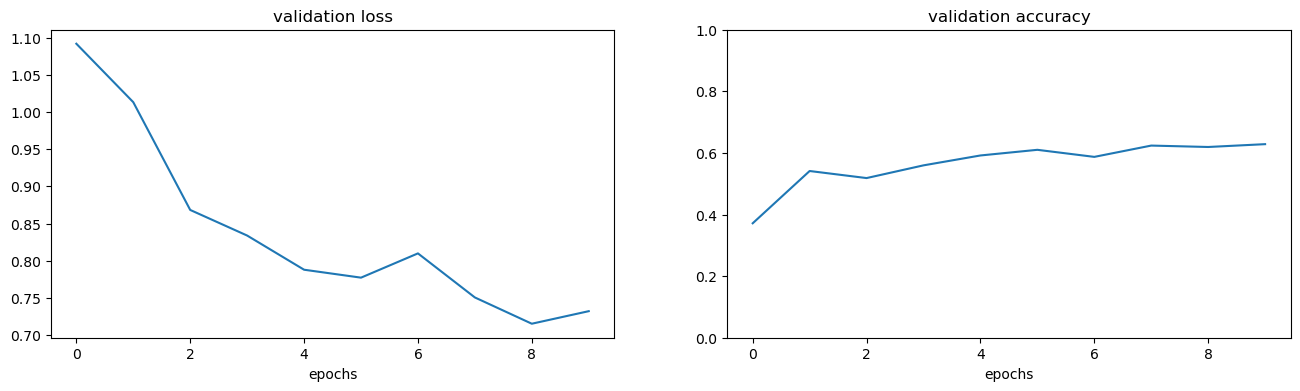

In [44]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

It does not seem that the model has overfitted. Loss gradually drops up to the 8th epoch, while it seems to stabilize around the 7th epoch. It might be worthwhile to run the model for a few more epochs, but we might risk overfitting.

In [37]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6277527213096619
Test accuracy: 0.7201834917068481


This model has achieved an accuracy of around 72%. That is reasonable if we consider a random guess would have a probability of around 33%.

### Transfer learning model

We will use the VGG16 model from Keras. It was trained on ImageNet with the weights being saved online. We will start with this model, remove the last layer, and insert a new layer representing our categories. We will then freeze all but the last layer. This will allow only the last classification layer to be trained, speeding up the process and benefiting from all the trained data done before.

#### Build

Here we load the model with the pre-trained weights

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)

We now create a new classification layer representing our classes and connect it to the second last from the VGG16 model.
Finally, we create a new model with the input being the same as the VGG16 model and the output being our layer.

In [46]:
inp = vgg.input
new_classification_layer = Dense(num_classes, activation='softmax')
out = new_classification_layer(vgg.layers[-2].output)

model_new = Model(inp, out)

We freeze the layers, keeping only the last trainable and compile the model.

In [49]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,272,835 (512.21 MB)

 Trainable params: 12,291 (48.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

#### Train

In [51]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 223s 29s/step - accuracy: 0.3396 - loss: 1.5012 - val_accuracy: 0.4908 - val_loss: 0.9222
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 222s 28s/step - accuracy: 0.4633 - loss: 0.9647 - val_accuracy: 0.5000 - val_loss: 0.8990
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 221s 28s/step - accuracy: 0.6273 - loss: 0.7605 - val_accuracy: 0.7294 - val_loss: 0.7169
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 226s 29s/step - accuracy: 0.7866 - loss: 0.6403 - val_accuracy: 0.7615 - val_loss: 0.6377
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 224s 29s/step - accuracy: 0.7898 - loss: 0.5668 - val_accuracy: 0.8165 - val_loss: 0.5656
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 221s 28s/step - accuracy: 0.8352 - loss: 0.5025 - val_accuracy: 0.7936 - val_loss: 0.5579
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 222s 28s/step - accuracy: 0.8417 - loss: 0.4668 - val_accuracy: 0.8165 - val_loss: 0.5163
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 222s 28s/step - accuracy: 0.8320 - loss: 0.4723 - val_accuracy: 0.8394 - val_loss:

#### Evaluation

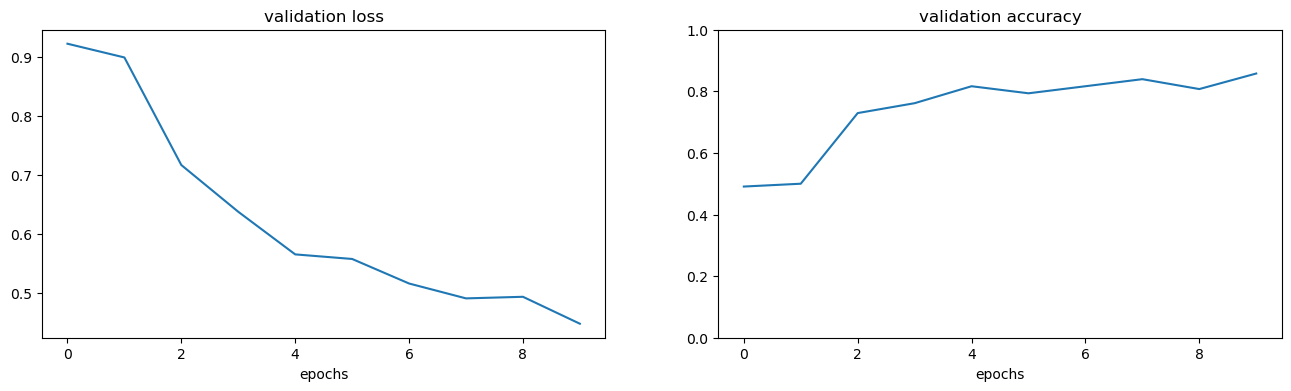

In [53]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Look at the graphics, we can see that the loss is still descending and the validation accuraty is clearly in a ascending trend.
It looks like we could benefit from training the model for a few more epochs in order to increase accuracy.

In [54]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.4246417284011841
Test accuracy: 0.8348624110221863


This model has achieved an accuracy of around 83%. It is a good accuracy, if we consider we used less than 1500 images. It is better than 2.5 times a random guess, and we probably could get it even better with a few more training epochs. 

## Comparison

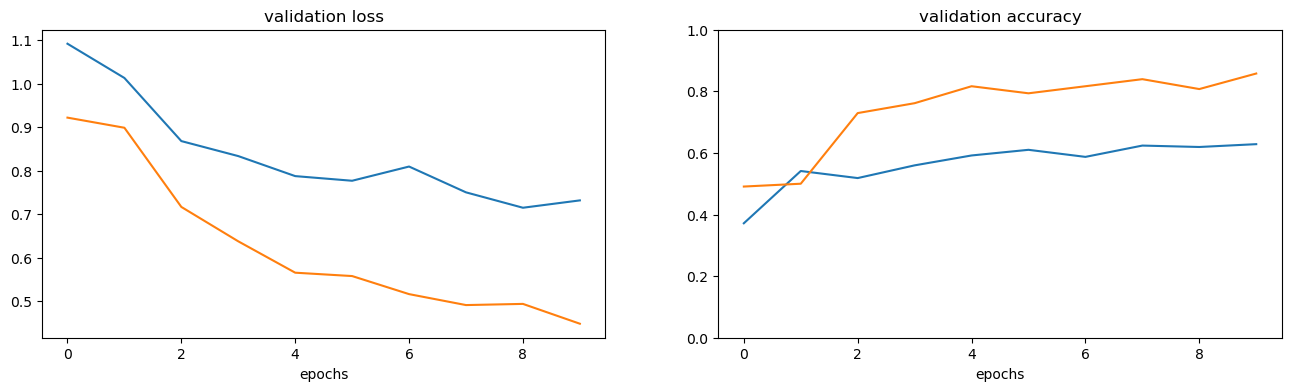

In [55]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Notice how our first model began to estabilize arround epcho 8, the new model continued to improve thrghout all the epochs, and probably out continue to improve for many epochs. Both loss and accuracy were better in almost all epochs, and we arrived at a better accuracy ( with room for further improvement).

## Conclusion

Transfer learning can be an effective technique to speed up the training of a new model. We can save on both data and time, which makes it a great tool when exploring new problems.